In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10/cifar-10-batches-py/test_batch
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10/cifar-10-batches-py/readme.html
/kaggle/input/cifar-10/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar-10/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar-10/cifar-10-batches-py/batches.meta
/kaggle/input/cifar-10/cifar-10-batches-py/test_batch
/kaggle/input/cifar-10/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar-10/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar-10/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar-10/cifar-10-batches-py/readme.html


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns





2025-05-05 17:17:50.095118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746465470.464401      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746465470.558741      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
folder_path = '/kaggle/input/cifar-10/cifar-10-batches-py'

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [4]:
X_train = X_train[:1000]
y_train = y_train[:1000]

print(X_train.shape)
print(y_train.shape)

(1000, 32, 32, 3)
(1000, 1)


In [5]:
#normalizzazione
X_train = X_train / 255.0
X_test = X_test / 255.0


#appiattimento dei target
y_Train = y_train.flatten()        #TARGET di train completo, pronti per l'utilizzo
y_Test = y_test.flatten()          #TARGET di test completo, pronti per l'utilizzo

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)



(1000, 32, 32, 3)
(1000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:

#appiattimento delle feature
X_Train = X_train.reshape(X_train.shape[0], -1)         #ESEMPI di train completo, pronti per l'utilizzo ma non standardizzati
X_test = X_test.reshape(X_test.shape[0], -1)            #ESEMPI di test completo, pronti per l'utilizzo ma non standardizzati

print(X_Train.shape)
print(X_test.shape)


(1000, 3072)
(10000, 3072)


In [7]:

#dizionario hyperparams => con i suoi 4 sottodizionari => per ognuno le sue molteplici combinazioni

hyperparams = {
    'LR': {
        'classifier': 'LR',
        'C': [0.001, 0.01, 0.1, 1],
        'solver': ['saga','lbfgs'],
        'max_iter': 2000
    },
    'KNN':{
        'classifier': 'KNN',
        'n_neighbors': list(range(1,10)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'SVM': {
        'classifier': 'SVM',
        'C': [0.001, 0.01, 0.1, 1],           
        'kernel': ['linear', 'rbf', 'poly']  
    },
   'DT': {
        'classifier': 'DT',
        'criterion': ['entropy'],          
        'max_depth': [5, 10, 20],                  
        'min_samples_split': [2, 5],               
        'min_samples_leaf': [1, 3]                 
   }
}

In [8]:
def pipeline(X_Train, y_Train, X_test, y_test, hyperparams):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_Train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=100)  # scegli il numero che preferisci
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)
    
    tipo_classificatore = hyperparams['classifier']
   
    if tipo_classificatore == 'LR':
        param_grid = {
        'C': hyperparams['C'], 
        'solver': hyperparams['solver']
        }
        modello_base = LogisticRegression(max_iter=hyperparams['max_iter'])     # l'ho levata dalla param grid e l'ho messa nel modello base perchè non faccio variare max_iter
        
        grid_search = GridSearchCV(modello_base, param_grid, cv=3, scoring='accuracy')
        grid_search.fit(X_train_scaled, y_Train)

             #estrazione del modello migliore
        modello_migliore = grid_search.best_estimator_

            # Predizione sul training set e sul test set
        pred_train = modello_migliore.predict(X_train_scaled)
        pred_test = modello_migliore.predict(X_test_scaled)
           
        # Calcolo delle metriche per il training set
        train_accuracy = accuracy_score(y_Train, pred_train)
        f1_train = f1_score(y_Train, pred_train, average='macro')
        matrice_confusione_train = confusion_matrix(y_Train, pred_train)

             # Calcolo delle metriche per il test set
        test_accuracy = accuracy_score(y_test, pred_test)
        f1_test = f1_score(y_test, pred_test, average='macro')
        matrice_confusione_test = confusion_matrix(y_test, pred_test)
        
         


    

        
    
    elif tipo_classificatore == 'KNN':
        param_grid = {
            'n_neighbors': hyperparams['n_neighbors'],
            'weights': hyperparams['weights'],
            'metric': hyperparams['metric']
        }
        modello_base = KNeighborsClassifier()
        grid_search = GridSearchCV(modello_base, param_grid, cv=3, scoring='accuracy')
        grid_search.fit(X_train_scaled, y_Train)

            #estrazione del modello migliore
        modello_migliore = grid_search.best_estimator_

            # Predizione sul training set e sul test set
        pred_train = modello_migliore.predict(X_train_scaled)
        pred_test = modello_migliore.predict(X_test_scaled)
           
        # Calcolo delle metriche per il training set
        train_accuracy = accuracy_score(y_Train, pred_train)
        f1_train = f1_score(y_Train, pred_train, average='macro')
        matrice_confusione_train = confusion_matrix(y_Train, pred_train)

             # Calcolo delle metriche per il test set
        test_accuracy = accuracy_score(y_test, pred_test)
        f1_test = f1_score(y_test, pred_test, average='macro')
        matrice_confusione_test = confusion_matrix(y_test, pred_test)
        

                                               
    
    elif tipo_classificatore == 'SVM':
         param_grid = {
        'C': hyperparams['C'],
        'kernel': hyperparams['kernel']
         }
         modello_base = SVC()
         grid_search = GridSearchCV(modello_base, param_grid, cv=3, scoring='accuracy')
         grid_search.fit(X_train_scaled, y_Train)

                      #estrazione del modello migliore
         modello_migliore = grid_search.best_estimator_

            # Predizione sul training set e sul test set
         pred_train = modello_migliore.predict(X_train_scaled)
         pred_test = modello_migliore.predict(X_test_scaled)
           
        # Calcolo delle metriche per il training set
         train_accuracy = accuracy_score(y_Train, pred_train)
         f1_train = f1_score(y_Train, pred_train, average='macro')
         matrice_confusione_train = confusion_matrix(y_Train, pred_train)

             # Calcolo delle metriche per il test set
         test_accuracy = accuracy_score(y_test, pred_test)
         f1_test = f1_score(y_test, pred_test, average='macro')
         matrice_confusione_test = confusion_matrix(y_test, pred_test)
        
        

   



                                                
    elif tipo_classificatore == 'DT':
        param_grid = {
            'max_depth': hyperparams['max_depth'],
            'min_samples_split': hyperparams['min_samples_split'],
            'min_samples_leaf': hyperparams['min_samples_leaf']
        }

        modello_base = DecisionTreeClassifier(criterion='entropy')
        grid_search = GridSearchCV(modello_base, param_grid, cv=3, scoring='accuracy')
        grid_search.fit(X_train_scaled, y_Train)

                     #estrazione del modello migliore
        modello_migliore = grid_search.best_estimator_

            # Predizione sul training set e sul test set
        pred_train = modello_migliore.predict(X_train_scaled)
        pred_test = modello_migliore.predict(X_test_scaled)
           
        # Calcolo delle metriche per il training set
        train_accuracy = accuracy_score(y_Train, pred_train)
        f1_train = f1_score(y_Train, pred_train, average='macro')
        matrice_confusione_train = confusion_matrix(y_Train, pred_train)

             # Calcolo delle metriche per il test set
        test_accuracy = accuracy_score(y_test, pred_test)
        f1_test = f1_score(y_test, pred_test, average='macro')
        matrice_confusione_test = confusion_matrix(y_test, pred_test)
        
         
    else:
        raise ValueError(f"Classificatore '{tipo_classificatore}' non supportato.")

  
    
    
    return train_accuracy, f1_train, matrice_confusione_train, test_accuracy, f1_test, matrice_confusione_test, modello_migliore,grid_search.best_params_





/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


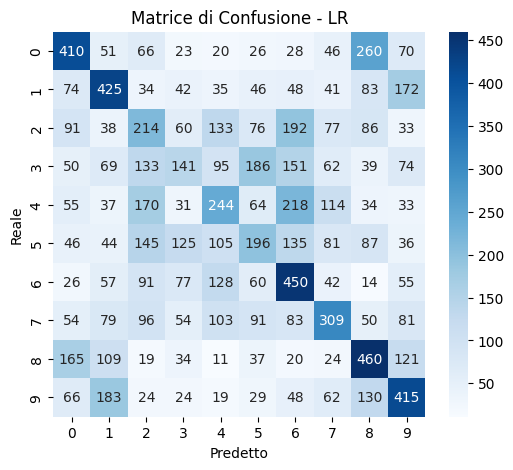

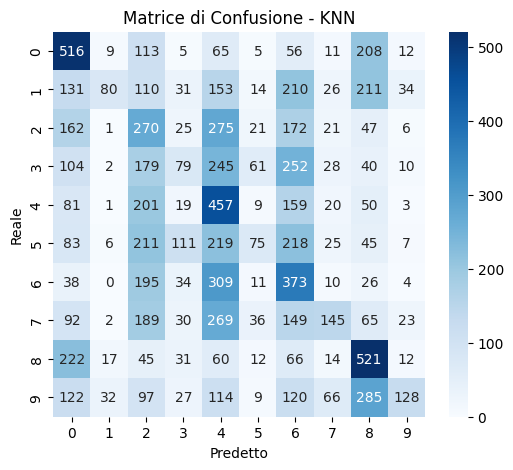

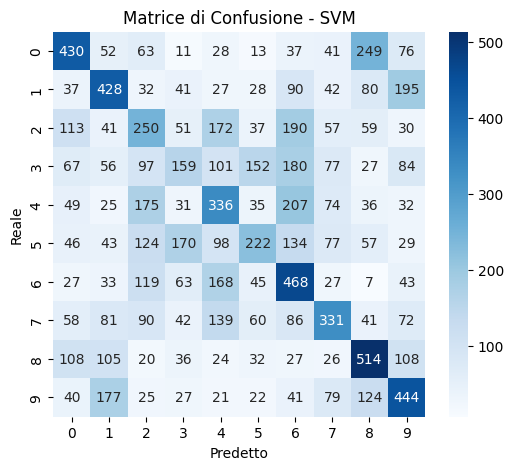

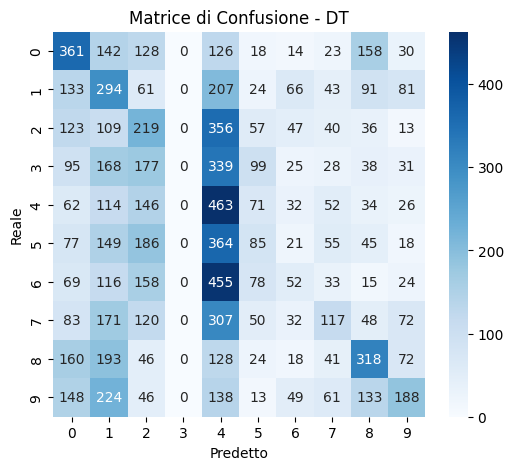

In [9]:

#ciclo for per salvare i modelli migliori di ogni classificatore(in risultato) in base alla metrica "accuracy"

risultato = []

for name, params in hyperparams.items():
    train_accuracy, f1_train, matrice_confusione_train, test_accuracy, f1_test, matrice_confusione_test, modello_migliore, parametri_migliori = pipeline(X_Train, y_Train, X_test, y_test, params)
    risultato.append({
        'name': name,
        'train_accuracy': train_accuracy,
        'f1_train': f1_train,
        'matrice_confusione_train': matrice_confusione_train,
        'test_accuracy': test_accuracy,
        'f1_test': f1_test,
        'matrice_confusione_test': matrice_confusione_test,
        'modello_migliore': modello_migliore,
        'parametri_migliori': parametri_migliori
    })
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrice_confusione_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice di Confusione - {name}")
    plt.xlabel("Predetto")
    plt.ylabel("Reale")
    plt.show()


  name  train_accuracy  test_accuracy   f1_test
2  SVM           0.728         0.3582  0.351891
0   LR           0.540         0.3264  0.319219
1  KNN           1.000         0.2644  0.237736
3   DT           0.345         0.2097  0.188090

MIGLIOR CLASSIFICATORE: SVM
 modello migliore: SVC(C=1)
 parametri migliori: {'C': 1, 'kernel': 'rbf'}

train Accuracy: 0.7280
 f1 train: 0.7291

test Accuracy: 0.3582
 F1 test: 0.3519

Composite score: 0.3541
 Matrice di confusione:
[[430  52  63  11  28  13  37  41 249  76]
 [ 37 428  32  41  27  28  90  42  80 195]
 [113  41 250  51 172  37 190  57  59  30]
 [ 67  56  97 159 101 152 180  77  27  84]
 [ 49  25 175  31 336  35 207  74  36  32]
 [ 46  43 124 170  98 222 134  77  57  29]
 [ 27  33 119  63 168  45 468  27   7  43]
 [ 58  81  90  42 139  60  86 331  41  72]
 [108 105  20  36  24  32  27  26 514 108]
 [ 40 177  25  27  21  22  41  79 124 444]]


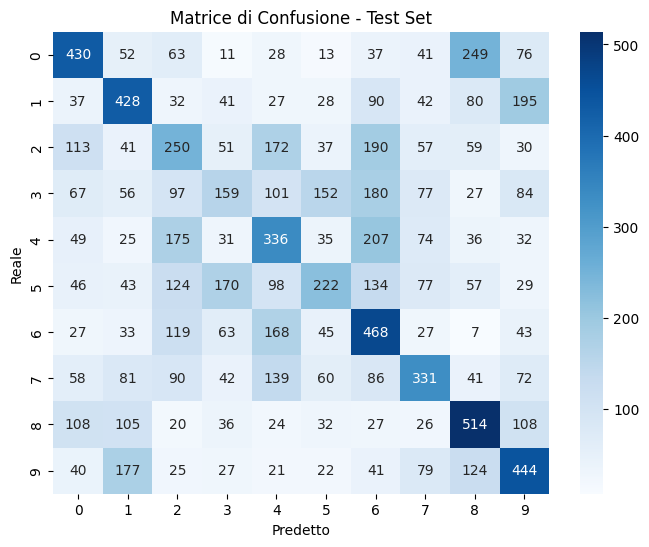

In [10]:


df = pd.DataFrame(risultato)
print(df[['name','train_accuracy','test_accuracy','f1_test']].sort_values(by='f1_test', ascending=False))   #tabella riassuntiva dei migliori 4 modelli

for r in risultato:
    r['composite_score'] = 0.35 * r['test_accuracy'] + 0.65 * r['f1_test']  #decidiamo il peso da dare a ciascuna metrica, aggiungendo il risultato come una chiave di risultato e valutando questa

best_model = max(risultato, key=lambda x: x['composite_score'])  #dizionario associato al miglior classificatore

print(f"\nMIGLIOR CLASSIFICATORE: {best_model['name']}")
print(f" modello migliore: {best_model['modello_migliore']}")
print(f" parametri migliori: {best_model['parametri_migliori']}")

print(f"\ntrain Accuracy: {best_model['train_accuracy']:.4f}")
print(f" f1 train: {best_model['f1_train']:.4f}")


print(f"\ntest Accuracy: {best_model['test_accuracy']:.4f}")
print(f" F1 test: {best_model['f1_test']:.4f}")

print(f"\nComposite score: {best_model['composite_score']:.4f}")
print(f" Matrice di confusione:\n{best_model['matrice_confusione_test']}")

mc = best_model['matrice_confusione_test']

# Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(mc, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice di Confusione - Test Set")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

